# Titanic Kaggle Competition: Using a Fast.AI tabular learner

In this notebook I implement a solution for the Titanic competition using a Fast.AI tabular learner.

## Downloading the dataset

Uncomment the lines below if you need to dataset.

For any advice on how to install kaggle, please refer to this blog post LINK

In [1]:
#!kaggle competitions download -c titanic

In [2]:
#!unzip titanic.zip

## Inspect the training data

Let's load the training data and have quick look

In [3]:
import pandas as pd

train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Using a Fast.AI tabular learner

The goal is not to create a perfect submission, but to simply train a model as fast as possible.

In [5]:
from fastai.tabular.all import *

path = "."

dls = TabularDataLoaders.from_csv('train.csv', path=path, y_names="Survived",
    cat_names = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'],
    cont_names = ['Age', 'Fare'],
    procs = [Categorify, FillMissing, Normalize])

In [6]:
dls.show_batch()

,Pclass,Sex,SibSp,Parch,Embarked,Age_na,Age,Fare,Survived
0,3,male,0,1,S,False,6.0,12.475000,1.0
1,3,male,0,0,S,False,18.0,8.299999,0.0
2,3,male,2,0,S,False,28.0,7.925000,0.0
3,3,female,0,0,Q,True,28.0,7.733300,1.0
4,3,female,0,0,S,False,27.0,7.925000,1.0
5,3,female,0,0,Q,False,18.0,6.749999,0.0
6,1,male,0,1,S,False,38.0,153.462502,0.0
7,2,male,0,0,S,True,28.0,-0.000001,0.0
8,2,female,1,0,S,False,27.0,21.000000,0.0
9,2,male,0,0,S,False,18.0,11.500001,0.0


In [7]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.551487,0.433037,0.612360,00:00
1,0.462697,0.451640,0.612360,00:00
2,0.395624,0.413267,0.612360,00:00
3,0.347306,0.361084,0.612360,00:00
4,0.307953,0.277068,0.612360,00:00
5,0.275046,0.276112,0.612360,00:00
6,0.248843,0.225474,0.612360,00:00
7,0.228679,0.216321,0.612360,00:00
8,0.213727,0.211212,0.612360,00:00
9,0.201521,0.211040,0.612360,00:00


In [8]:
learn.show_results()

,Pclass,Sex,SibSp,Parch,Embarked,Age_na,Age,Fare,Survived,Survived_pred
0,3.0,2.0,1.0,1.0,2.0,2.0,-0.084985,-0.501905,0.0,0.002015
1,2.0,2.0,1.0,1.0,3.0,1.0,0.767723,-0.394451,0.0,0.035013
2,2.0,2.0,2.0,1.0,3.0,1.0,0.380129,-0.230711,0.0,0.145823
3,3.0,2.0,3.0,1.0,3.0,1.0,0.922761,-0.371767,0.0,-0.092227
4,3.0,2.0,1.0,1.0,3.0,1.0,-0.782655,-0.498921,0.0,-0.039271
5,3.0,2.0,1.0,1.0,1.0,2.0,-0.084985,-0.512651,0.0,-0.019110
6,3.0,2.0,1.0,1.0,3.0,2.0,-0.084985,-0.498921,0.0,-0.099687
7,2.0,2.0,1.0,1.0,3.0,1.0,-0.472579,-0.445620,0.0,0.023831
8,2.0,2.0,1.0,1.0,3.0,2.0,-0.084985,-0.660529,0.0,-0.013882


Let's have a look at the test set:

In [9]:
test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


There is a line in which the fare value in NaN (null). Let's select and fix that:

In [10]:
# select as suggested by https://datatofish.com/rows-with-nan-pandas-dataframe/
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [11]:
test['Fare'] = test['Fare'].fillna(0)

In [12]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Creating the predictions as suggested here: https://forums.fast.ai/t/tabular-learner-prediction-using-data-frame/90534/2

In [13]:
test_dl = learn.dls.test_dl(test)
preds, _ = learn.get_preds(dl=test_dl)

In [14]:
preds[:5]

tensor([[-0.0372],
        [ 0.3313],
        [ 0.1413],
        [-0.0250],
        [ 0.3564]])

In [15]:
preds.size()

torch.Size([418, 1])

Adding the tensor to the dataframe, as suggested here: https://stackoverflow.com/questions/63163020/add-tensor-to-a-dataframe

In [16]:
preds.squeeze()[:5]

tensor([-0.0372,  0.3313,  0.1413, -0.0250,  0.3564])

In [17]:
test['Survived_pred'] = preds.squeeze()

In [18]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_pred
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,-0.037249
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.331290
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.141272
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,-0.025019
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.356389


What do these values mean? Let's look at `min` and `max`

In [19]:
print(f"Survived_pred: Min: {test['Survived_pred'].min()} Max: {test['Survived_pred'].max()}") #test.Survived_pred.max()

Survived_pred: Min: -0.40187036991119385 Max: 1.304780125617981


Let's just say that any value greater than 0.5 means survived.

Deriving the survived-column:

In [20]:
test['Survived'] = [ 1 if element > 0.5 else 0 for element in preds.squeeze()]

In [21]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_pred,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,-0.037249,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.331290,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.141272,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,-0.025019,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.356389,0


Creating a new dataframe with just the columns `PassengerId` and `Survived` (as requested for the submission of the results):

In [22]:
test[['PassengerId', 'Survived']].head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [23]:
submission = test[['PassengerId', 'Survived']]

In [24]:
submission.to_csv('submission.csv', index=False)

I uploaded the results, and here we go - better then random ;)

![First Submission](first_submission.png)

How can we improve the results? More training? Interpreting the data a different way?

Let's have a look at the distrbution of the predictions to see if we should set the threshold differently:

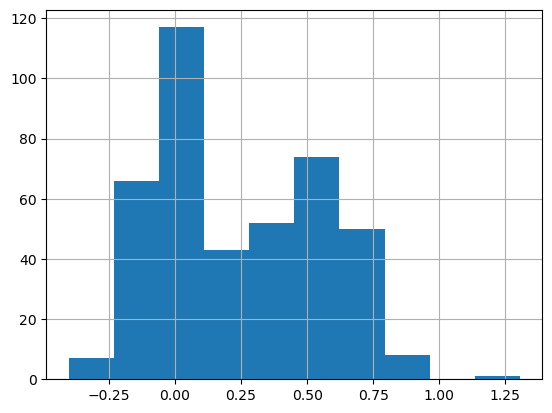

In [25]:
test.Survived_pred.hist();

In [26]:
test.Survived_pred.mean()

0.24192484

In [27]:
test.Survived_pred.median()

0.14715469

In [28]:
test['Survived'] = [ 1 if element > 0.3 else 0 for element in preds.squeeze()]
submission2 = test[['PassengerId', 'Survived']]
submission2.to_csv('submission2.csv', index=False)

Bummer, my score went down: Score: 0.7177

One more attemp: Let's set it to 0.4:

In [29]:
test['Survived'] = [ 1 if element > 0.4 else 0 for element in preds.squeeze()]
submission3 = test[['PassengerId', 'Survived']]
submission3.to_csv('submission3.csv', index=False)

Also not good: Score: 0.71531

One more attemp: Let's set it to 0.6:

In [30]:
test['Survived'] = [ 1 if element > 0.6 else 0 for element in preds.squeeze()]
submission4 = test[['PassengerId', 'Survived']]
submission4.to_csv('submission4.csv', index=False)

Getting better: **Score: 0.74162**

![submission02](submission02.png)

In [31]:
test['Survived'] = [ 1 if element > 0.7 else 0 for element in preds.squeeze()]
submission5 = test[['PassengerId', 'Survived']]
submission5.to_csv('submission5.csv', index=False)

Going down again: Score: 0.69856